In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import os
import cftime
import copy
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils
import main
import plot_utils


In [2]:
fold = '../../data/satellite/sst_subskin_l4/'
files = utils.dirtodict(fold)['.files']
ds_subskin = xr.open_mfdataset(files).convert_calendar('noleap').compute()

fold = '../../data/satellite/sst_rep_l4/'
files = utils.dirtodict(fold)['.files']
ds_rep = xr.open_mfdataset(files)

In [3]:
year = 2021

locs = {'1': {'lat': 36.342270, 'lon': -4.099501},
        '2': {'lat': 39.408549, 'lon': 23.784501}}

In [4]:
max_daily = {}

#Max daily subskin SST for year under analysis
for loc in locs.keys():

    max_sst_y = utils.retrieve_one_point(ds_subskin,
                                    lon=locs[loc]['lon'], lat=locs[loc]['lat'],
                                    years = [year])
    max_sst_y = max_sst_y.resample(time='1D').max()
    max_sst_y = max_sst_y.analysed_sst - 273.15
    max_daily[loc] = max_sst_y

In [6]:
baselines = ["fixed_baseline", "moving_baseline"]
mhws = {loc: {baseline: None for baseline in baselines} for loc in ["1", "2"]}

for loc in ["1", "2"]:
    for baseline in baselines:
        mhws[loc][baseline] = main.MHW_metrics_one_point(
            utils.retrieve_one_point(ds_rep, lon=locs[loc]['lon'], lat=locs[loc]['lat']),
            baseline_years=20,
            baseline_type=baseline,
            year=year,
            error=True,
        )

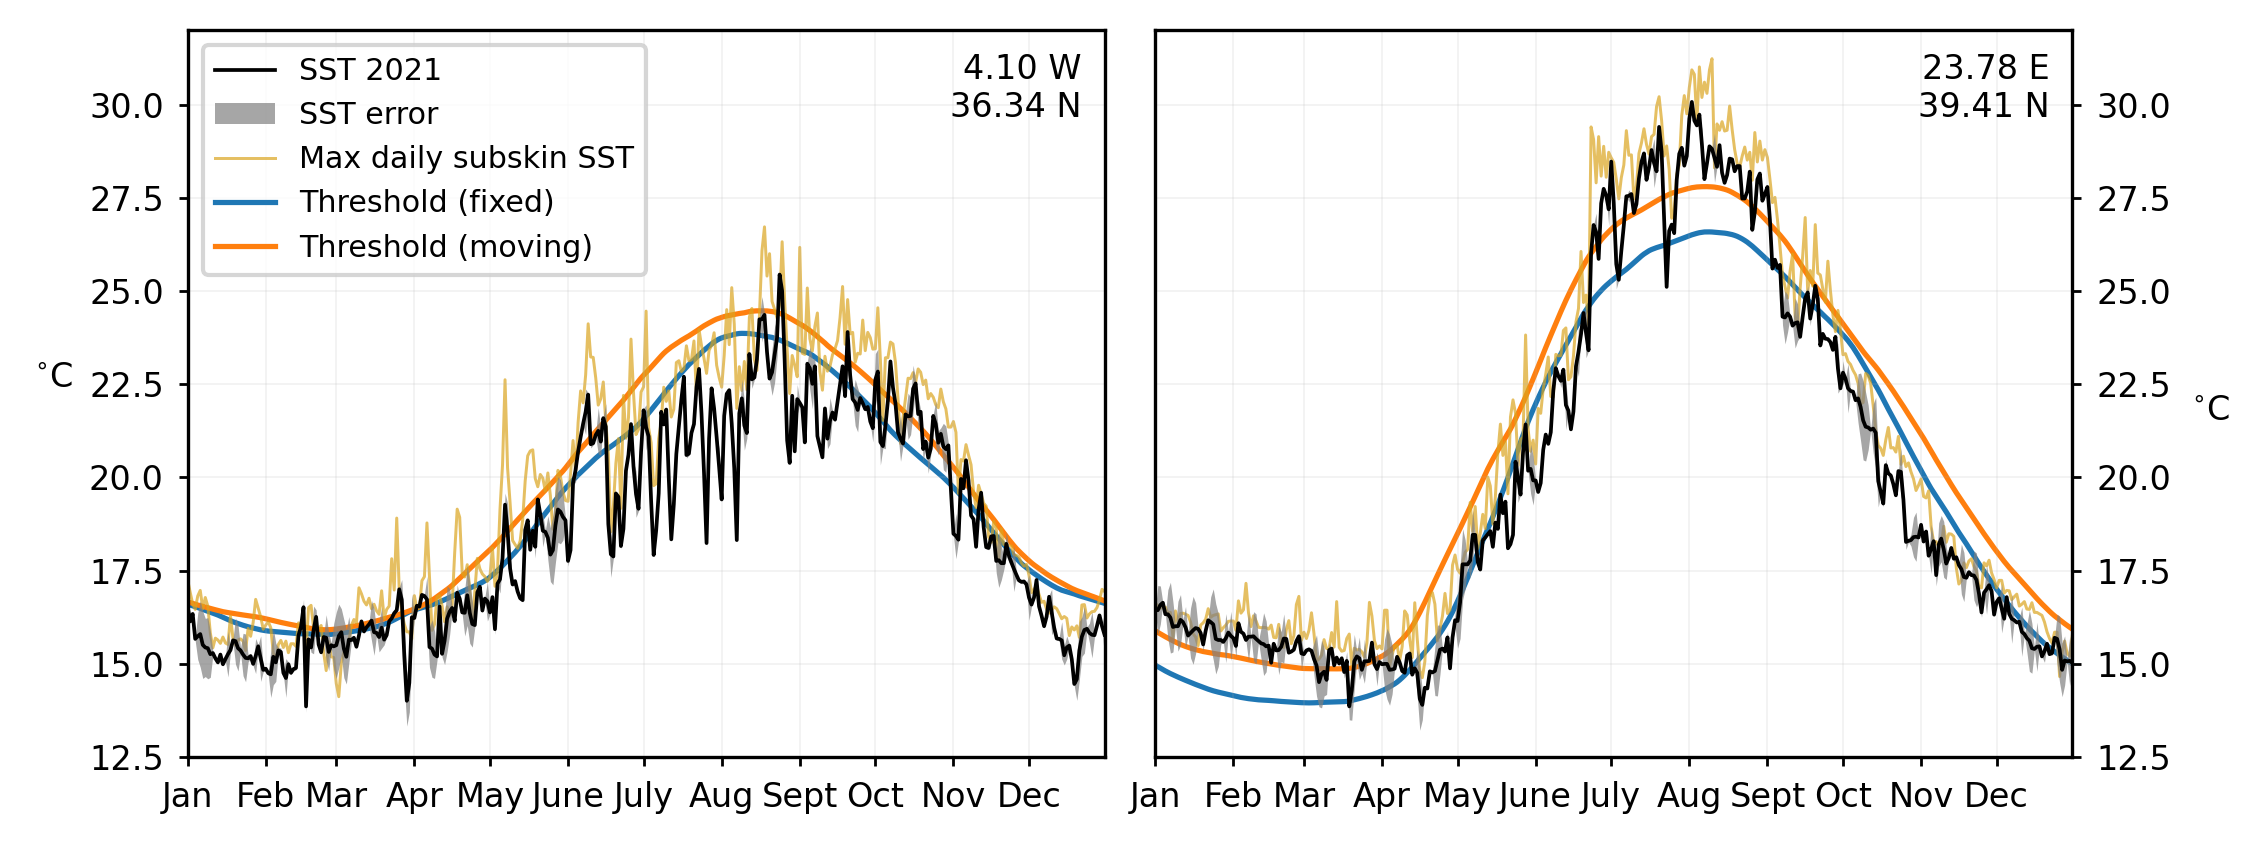

In [11]:
savefold = '../../figures/'
savepath = os.path.join(savefold, 'fig_S3.jpeg')


fig_size=20
text_size=1.2

y_lim = [12.5,32]

fig, ax, fs, text_size = plot_utils.initialize_figure(
    fig_size=20, ratio=2.75, text_size=text_size, subplots=(1,2))

months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July','Aug', 'Sept', 'Oct', 'Nov', 'Dec']
m_doy=[1,32,60,91,121,152,182,213,244,274,305,335]
tt=list(range(1, 365+1))

lw = 0.2*fs

for i,loc in enumerate(['1','2']):
    fixed_thres = mhws[loc]['fixed_baseline']['pctl']-273.15
    moving_thres = mhws[loc]['moving_baseline']['pctl']-273.15
    sst = mhws[loc]['fixed_baseline']['sst']-273.15
    error = mhws[loc]['fixed_baseline']['error']
    max_sst = max_daily[loc]

    ax[0][i].set_xticks(m_doy)
    ax[0][i].set_xticklabels(months, size=text_size*fs*1.5)
    ax[0][i].set_xlim(tt[0], tt[-1])
    ax[0][i].set_ylabel('$^\circ$$\!$C',size=text_size*fs*1.5, rotation=0, labelpad=fs*2)



    if locs[loc]["lon"] > 0:
        lon_text = f'{locs[loc]["lon"]:0.02f} E'
    else:
        lon_text = f'{abs(locs[loc]["lon"]):0.02f} W'

    if locs[loc]["lat"] > 0:
        lat_text = f'{locs[loc]["lat"]:0.02f} N'
    else:
        lat_text = f'{abs(locs[loc]["lat"]):0.02f} S'

    text = lon_text + '\n' + lat_text
    ax[0][i].text(0.975,0.88, text, transform=ax[0][i].transAxes, fontsize=text_size*fs*1.5, ha='right')


    ax[0][i].plot(tt, sst, c='k', lw=lw, label=f'SST {year}', zorder=3)
    ax[0][i].fill_between(tt,sst-error,sst+error,
                    alpha=0.7,
                    color='gray',
                    lw=0, 
                    label = 'SST error', zorder=2)
    ax[0][i].plot(tt, max_sst, c='goldenrod', alpha=0.7, lw=lw*0.8, label='Max daily subskin SST', zorder=1)
    ax[0][i].plot(tt, fixed_thres, lw=lw*1.4, label='Threshold (fixed)', zorder=0)
    ax[0][i].plot(tt, moving_thres, lw=lw*1.4, label='Threshold (moving)', zorder=0)


    
    

    if y_lim:
        ax[0][i].set_ylim(y_lim[0], y_lim[1])

       

ax[0][1].yaxis.tick_right()
ax[0][1].yaxis.set_label_position("right")

ax[0][0].legend(loc='upper left', fontsize=text_size*fs*1.35)

if savepath!='':
    plt.savefig(savepath, bbox_inches="tight", dpi=300)